<a href="https://colab.research.google.com/github/UCLAbrucequ/BioFaceNet-Pytorch-repo/blob/main/BioFaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import libraries and modules
import torch
import torchvision
import torch.nn as nn


import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils



from scipy.io import loadmat
from torchvision.datasets import CelebA
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/VMG/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Number of Total images
n_images = 50765

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 1e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
#check device

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

print(device)
#The program is running on cuda

cpu


In [ ]:
#unzip the file
#only run once

!unzip -u "/content/drive/MyDrive/VMG/img_align_celeba.zip" -d "/content/drive/MyDrive/VMG/celeba"

In [ ]:
#Define transformations for the training set, resize the image, centercrop, and convert it to tensors
train_transformations = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#Load the training set
train_set = CelebA(root='/content/drive/MyDrive/VMG', split = 'train' , transform=train_transformations, download=False)

#Create a loader for the training set
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=workers)


#Load the validation set
valid_set = CelebA(root='/content/drive/MyDrive/VMG', split='valid', transform= train_transformations, download=False)

#Load the test data
test_set = CelebA(root = '/content/drive/MyDrive/VMG', split = 'test', transform= train_transformations, download=False)


#Create a test dataloader for the test set
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = batch_size, shuffle=True, num_workers=workers)

In [ ]:
print(train_set)
print(valid_set)
print(test_set)

Dataset CelebA
    Number of datapoints: 162770
    Root location: /content/drive/MyDrive/VMG
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CelebA
    Number of datapoints: 19867
    Root location: /content/drive/MyDrive/VMG
    Target type: ['attr']
    Split: valid
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CelebA
    Number of datapoints: 19962
    Root location: /content/drive/MyDrive/VMG
    Target type: ['attr']
    Split: test
    StandardTransform
Transform: Compose

[tensor(-1.), tensor(1.)]


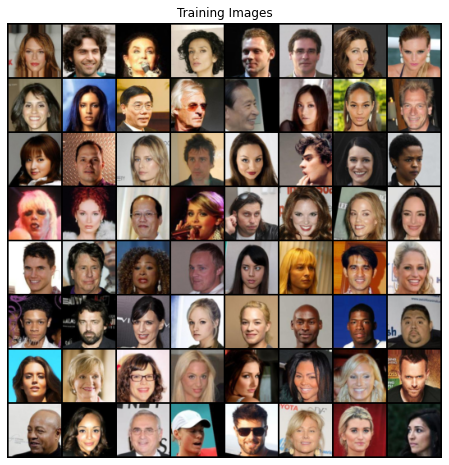

In [ ]:
#Plot some training samples
dataiter = iter(train_loader)
images, labels  = next(dataiter)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")


#print(np.transpose(vutils.make_grid(images.to(device)[:1], padding=2, normalize=True).cpu(),(0,1,2)).shape)
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print([torch.min(images), torch.max(images)])

In [ ]:
print("Image batch dimensions:", images.shape)
print("Image label dimensions:", labels.shape)

Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64, 40])


In [ ]:
def setup():

  cmf = loadmat('/content/drive/MyDrive/VMG/Matlab Files/rgbCMF.mat');

	#PCA model for camera sensitivities
  [mu, PC, EVpca] = CameraSensitivityPCA(cmf);

  LightVectorSize = np.single(15);
  wavelength = np.single(33);
  bSize = np.single(2);


  illF = loadmat('/content/drive/MyDrive/VMG/Matlab Files/illF.mat');
  illF_array = illF['illF'];
  illF = np.reshape(illF_array, [1,1,33,12]);

  illumDmeasured = loadmat('/content/drive/MyDrive/VMG/Matlab Files/illumDmeasured.mat');
  illumDmeasured = illumDmeasured['illumDmeasured'];
  illumDmeasured_array = np.transpose(illumDmeasured);
  illumDmeasured = np.reshape(illumDmeasured_array,[1,1,33,22]);

	#A
  illumA = loadmat('/content/drive/MyDrive/VMG/Matlab Files/illumA.mat');
  illumA_array = illumA['illumA'];
  illumA = illumA_array/(np.sum(illumA_array));

	#D
  illumDNorm = np.single(np.full((1,1, 33,22),0));
  for i in range(0, 22):
    illumDNorm[0,0,:,i] = illumDmeasured[0,0,:,i]/np.sum(illumDmeasured[0,0,:,i]);

	#F
  illumFNorm = np.single(np.full((1,1, 33,22),0));
  for i in range(0,12):
    illumFNorm[0,0,:,i] = illF[0,0,:,i]/np.sum(illF[0,0,:,i]);

def CameraSensitivityPCA(cmf):
  X = np.zeros((99,28))
  Y = np.zeros((99,28))


  redS = cmf['rgbCMF'][0,0]
  greenS = cmf['rgbCMF'][0,1]
  blueS = cmf['rgbCMF'][0,2]

  for i in range (0,28,1):
    Y[0:33,i] = redS[:,i]/sum(redS[:,i])
    Y[33:66,i] = greenS[:,i]/sum(greenS[:,i])
    Y[66:99,i] = blueS[:,i]/sum(blueS[:,i])

  PC = loadmat('/content/drive/MyDrive/VMG/Matlab Files/PC.mat')
  PC = PC['PC']

  mu = loadmat('/content/drive/MyDrive/VMG/Matlab Files/mu.mat')
  mu = mu['mu']

  EVpca = loadmat('/content/drive/MyDrive/VMG/Matlab Files/EVpca.mat')
  EVpca = EVpca['EVpca']

  return [mu, PC, EVpca]

setup();

In [ ]:
nfilters = np.single([32,64,128,256,512])
nlayers = np.size(nfilters)
print(nlayers)

5


In [ ]:
#Define class Unit
# Class Unit contains a convolutional layer, a batch normalization layer, and a Relu layer

class Unit(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Unit, self).__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn = nn.BatchNorm2d(num_features = out_channels)
    self.relu = nn.ReLU()

  def forward(self, input):
    output = self.conv(input)
    output = self.bn(output)
    output = self.relu(output)


    return output
  

In [ ]:
#Encoder & Decoder


#TODO:
  # X_skip should be a tensor




class Net(nn.Module):
  def __init__(self, num_classes = 4):
    super(Net, self).__init__()


  #Encoder Layers

    #First loop
    self.unit1 = Unit(in_channels=3, out_channels=nfilters[0])
    self.unit2 = Unit(in_channels=nfilters[0], out_channels=nfilters[0])
    self.unit3 = Unit(in_channels=nfilters[0], out_channels=nfilters[0])

    self.x_skip[0] = self.unit3

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Second loop
    self.unit4 = Unit(in_channels=nfilters[0], out_channels=nfilters[1])
    self.unit5 = Unit(in_channels=nfilters[1], out_channels=nfilters[1])
    self.untt6 = Unit(in_channels=nfilters[1], out_channels=nfilters[1])

    self.x_skip[1] = self.unit6

    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


    #Third loop
    self.unit7 = Unit(in_channels=nfilters[1], out_channels=nfilters[2])
    self.unit8 = Unit(in_channels=nfilters[2], out_channels=nfilters[2])
    self.unit9 = Unit(in_channels=nfilters[2], out_channels=nfilters[2])

    self.x_skip[2] = self.unit9

    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Encoder4
    self.unit10 = Unit(in_channels=nfilters[2], out_channels=nfilters[3])
    self.unit11 = Unit(in_channels=nfilters[3], out_channels=nfilters[3])
    self.unit12 = Unit(in_channels=nfilters[3], out_channels=nfilters[3])

    self.x_skip[3] = self.unit12

    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Last loop
    self.unit13 = Unit(in_channels=nfilters[3], out_channels=nfilters[4])
    self.unit14 = Unit(in_channels=nfilters[4], out_channels=nfilters[4])
    self.unit15 = Unit(in_channels=nfilters[4], out_channels=nfilters[4])
    self.y = self.unit15



    self.encoder1 = nn.Sequential(self.unit1, self.unit2, self.unit3)
    self.encoder2 = nn.Sequential(self.pool1, self.unit4, self.unit5, self.unit6)
    self.encoder3 = nn.Sequential(self.pool2, self.unit7, self.unit8, self.unit9)
    self.encoder4 = nn.Sequential(self.pool3, self.unit10, self.unit11, self.unit12)
    self.encoder5 = nn.Sequential(self.pool4, self.unit13, self.unit14, self.unit15)





    #self.encoder = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 #,self.pool2, self.unit7, self.unit8, self.unit9, self.pool3, self.unit10, self.unit11, self.unit12, self.pool4,
                                 #self.unit13, self.unit14, self.unit15)
    


  #Decoder Layers

    #i == 4
    self.upsample1 = nn.Upsample()
    #cat in forward

    self.dunit1 = Unit(in_channels=nfilters[3]+nfilters[4], out_channels=nfilters[3])
    self.dunit2 = Unit(in_channels=nfilters[3], out_channels=nfilters[3])
    self.dunit3 = Unit(in_channels=nfilters[3], out_channels=nfilters[3])


    #i == 3
    self.upsample2 = nn.Upsample()

    #cat in forward
    self.dunit4 = Unit(in_channels=nfilters[2]+nfilters[3], out_channels=nfilters[2])
    self.dunit5 = Unit(in_channels=nfilters[2], out_channels=nfilters[2])
    self.dunit6 = Unit(in_channels=nfilters[2], out_channels=nfilters[2])


    #i == 2
    self.upsample3 = nn.Upsample()


    #cat in forward
    self.dunit7 = Unit(in_channels=nfilters[1]+nfilters[2], out_channels=nfilters[1])
    self.dunit8 = Unit(in_channels=nfilters[1], out_channels=nfilters[1])
    self.dunit9 = Unit(in_channels=nfilters[1], out_channels=nfilters[1])



    #i == 1
    self.upsample4 = nn.Upsample()


    #cat in forward
    self.dunit10 = Unit(in_channels=nfilters[0]+nfilters[1], out_channels=nfilters[0])
    self.dunit11 = Unit(in_channels=nfilters[0], out_channels=nfilters[0])
    self.dunit12 = Unit(in_channels=nfilters[0], out_channels=nfilters[0])



    #Final prediction 
    self.dfinal = Unit(in_channels=nfilters[0], out_channels=1)
    

    self.dseq1 = nn.Sequential(self.dunit1, self.dunit2, self.dunit3)
    self.dseq2 = nn.Sequential(self.dunit4, self.dunit5, self.dunit6)
    self.dseq3 = nn.Sequential(self.dunit7, self.dunit8, self.dunit9)
    self.dseq4 = nn.Sequential(self.dunit10, self.dunit11, self.dunit12)
    self.doubleConv3 = nn.Sequential(self.unit11, self.unit12)
    self.doubleConv2 = nn.Sequential(self.unit8, self.unit9)
    self.doubleConv1 = nn.Sequential(self.unit5, self.unit6)
    self.doubleConv0 = nn.Sequential(self.unit2, self.unit3)


          

      

  def forward(self, input):

    #Encoder

    x_skip[0] = self.encoder1(input)
    x_skip[1] = self.encoder2(x_skip[0])
    x_skip[2] = self.encoder3(x_skip[1])
    x_skip[3] = self.encoder4(x_skip[2])
    y = self.encoder5(x_skip[5])


    #Multiple Decoders

    for c in range(1, num_classes+1): # c = 1, 2, ... , num_classes
      #cat dim = 2
      for i in range(nlayers-1, 0, -1):
        if i == nlayers-1:
          x = self.upsample1(y)
          x = torch.cat((x, x_skip[i-1]), dim = 2)
          x = self.dseq1(x)
          x = self.doubleConv3(x)
        elif i == nlayers-2:
          x = self.upsample1(x)
          x = torch.cat((x, x_skip[i-1]), dim = 2)
          x = self.dseq2(x)
          x = self.doubleConv2(x)
        elif i == nlayers-3:
          x = self.upsample1(x)
          x = torch.cat((x,x_skip[i-1]), dim = 2)
          x = self.dseq3(x)
          x = self.doubleConv1(x)
        elif i ==nlayers-4:
          x = self.upsample1(x)
          x = torch.cat((x, x_skip[i-1]), dim = 2)
          x = self.dseq4(x)
          x = self.doubleConv0(x)
      
      #Final Prediction
      x = self.dfinal(x)

      if c == 1:
        z = x
      else:
        z = torch.cat((z,x), dim = 2)

    x = z


    #Fully Connected
    fc1 = nn.Linear()





    return [x, y]





#TODO:
#     Define the Model
#     Set the parameters
model = Net().to(device)

print(model)














TypeError: ignored

In [ ]:
# Function CNN
def CNN(images, nfilters, nclass, LightVectorSize,bSize):
  [x, y] = 